# Switching on a Light Bulb
When a light bulb is switched on, the current through the filament leads to a temperature increase. After a short time there will be an equlibrium between the power delivered by the voltage supply and the power lost to radiation.

Derive a model for the temperature increase as a function of time and apply it to realistic values for a typical light bulb.

### Deriving the model

The energy delivered by the voltage supply is

$\textrm{d}E_{el} = P \textrm{d}t = \frac{\Delta V^2}{R(T)} \textrm{d}t = \frac{\Delta V^2}{R_{20}(1+\alpha_{20} (T-T_{20}))}\textrm{d}t = \frac{\Delta V^2}{\rho_{20}\frac{L}{\pi (d/2)^2}(1+\alpha_{20} (T-T_{20}))}\textrm{d}t$

where $\Delta V$ is the source voltage, $R_{20}$ the resistance at ambient temperature ($T_{20}$), $\alpha_{20}$ the temperature coefficient, and $T$ the current temperature.

The radiation energy is

$\textrm{d}E_{rad} = I(T) A \textrm{d}t = \varepsilon \sigma (T^4-T_{20}^4) \pi d L \textrm{d}t$ 

where $\varepsilon$ is the emissivity of the filament, $\sigma$ the Stefan-Boltzmann constant, and $d$ and $L$ the diameter and length of the filament. The term containing the ambient temperature $T_20$ takes into account the energy absorbed from the environment.

The net energy leads to a temperature increase $\textrm{d}T$ according to

$\textrm{d}E_{net} = \textrm{d}E_{el} - \textrm{d}E_{rad} = c m \textrm{d}T = c \rho V \textrm{d}T = c \rho \pi (d/2)^2 L \textrm{d}T$

where $c$ is the specific heat, and $\rho$ the density of the filament.

Solving for the rate of change of the temperature, we find

$\frac{\textrm{d}T}{\textrm{d}t} = \frac{1}{c \rho \pi (d/2)^2 L)} \left( \frac{\Delta V^2 \pi (d/2)^2}{\rho_{20} L (1+\alpha_{20} (T-T_{20}))} - \varepsilon \sigma (T^4-T_{20}^4) \pi d L \right)$

This is a *differential equation* for the temperature $T$ as a function of time $t$. It can be solved numerically usingt the function *solve_ivp* in SciPy.

### Implementing the model

#### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.constants import sigma, pi

#### Define constants

In [3]:
c = 134 # specific heat of tungsten (J/(kg K))
rh = 19.3e3 # density of tungsten (kg/m^3)
rel = 5.5e-8 # resistivity of tungsten at 20°C (Ω m)
al = 4.6e-3 # temperature coefficient for tungsten (1/K)
eps = 0.44 # emissivity of tungsten

d = 40e-6 # diameter of filament (m)
L = 1.15 # length of filament (m)
T20 = 293 # ambient temperature (K)
V = 230 # source voltage (V)

k1 = c * rh * pi * (d/2)**2 * L
k2 = V**2 * pi * (d/2)**2 / (rel * L)
k3 = eps * sigma * pi * d * L

#### Define RHS of differential equation

In [4]:
def dTdt(t, T):
    return 1/k1 * (k2 / (1 + al * (T - T20)) - k3 * (T**4 - T20**4))

### Solution and analysis

#### Solve differential equation

In [10]:
tmax = 0.12 # upper limit of time interval
t_range = [0, tmax] # time interval (s)
init = [T20] # initial temperature (K)

t = np.linspace(0, tmax, 100) # times used for plot

sol = solve_ivp(dTdt, t_range, init, dense_output=True) # solve DE

T = sol.sol(t)[0] # evaluate solution at given times

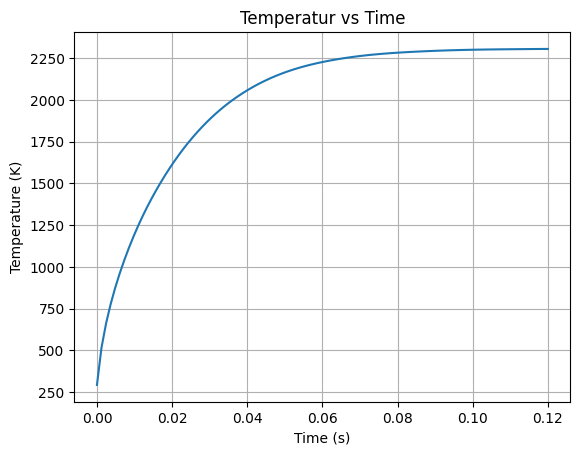

equilibrium temperature: 2306 K


In [16]:
plt.plot(t, T)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Temperatur vs Time')
plt.grid()
plt.show()

print(f'equilibrium temperature: {T[-1]:.0f} K')

The filament heats up to 2300 K within about 0.1 s. Both the equilibrium temperature and the time look realistic.

#### Analysis

In [17]:
# define function for input power
def Pel(T):
    return k2 / (1 + al * (T - T20))


# define function for radiation power
def Prad(T):
    return k3 * (T**4 - T20**4)

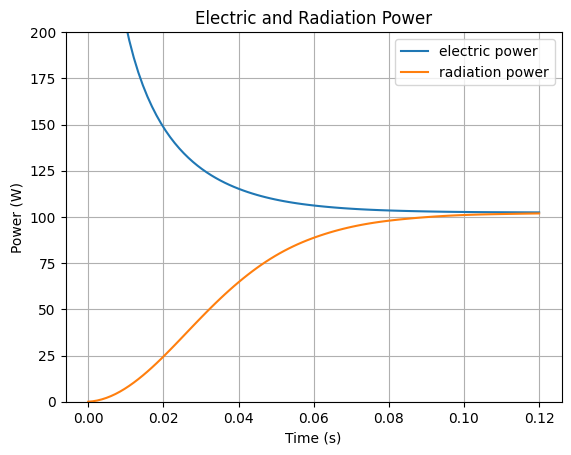

initial electric power: 1051 W
final electric power: 102 W


In [19]:
plt.plot(t, Pel(T), label='electric power')
plt.plot(t, Prad(T), label='radiation power')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.ylim(0, 200)
plt.title('Electric and Radiation Power')
plt.legend()
plt.grid()
plt.show()

print(f'initial electric power: {Pel(T20):.0f} W')
print(f'final electric power: {Pel(T[-1]):.0f} W')

The initial electric power is very high, but quickly drops to 100 W. The radiation starts from 0 and quickly increases to 100 W.

In [20]:
# define function for resistance
def R(T):
    return rel * L / (pi * (d/2)**2) * (1 + al * (T - T20))

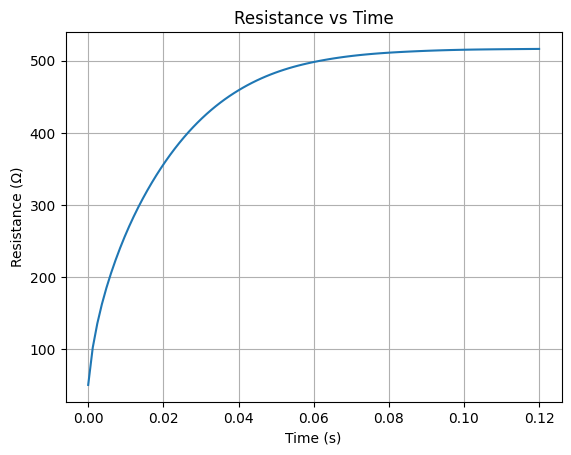

initial resistance: 50 Ω
final resistance: 516 Ω


In [22]:
plt.plot(t, R(T), label='Resistance')
plt.xlabel('Time (s)')
plt.ylabel('Resistance (Ω)')
plt.title('Resistance vs Time')
plt.grid()
plt.show()

print(f'initial resistance: {R(T20):.0f} Ω')
print(f'final resistance: {R(T[-1]):.0f} Ω')

The resistance increases from 62 Ω at ambient temperature to about 500 Ω when the filament is hot.

### Refining the model
So far we have assumed a linear relation between resistivity and temperature. An improved model should include a more realistic relation based on measured data.

#### Resistivity
We use data from *Formulae, Tables, Concepts* to interpolate the resistivity at higher temperatures.

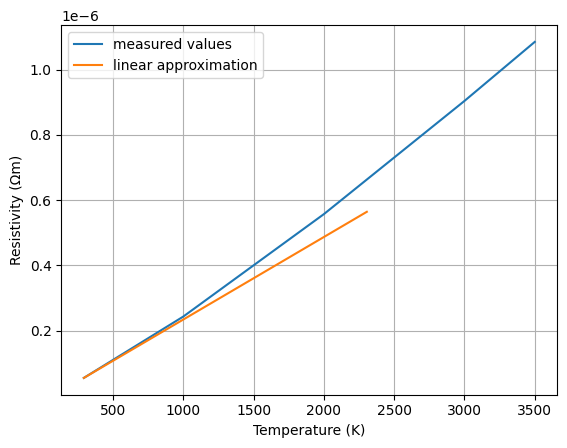

In [23]:
temperature = np.array([20, 727, 1727, 2727, 3227]) + 273 # temperatures (K)
resistivity = np.array([5.5, 24.3, 55.7, 90.4, 108.5]) * 1e-8 # resistivity (Ωm)

plt.plot(temperature, resistivity, label='measured values')
plt.plot(T, rel * (1 + al * (T - T20)), label='linear approximation')
plt.legend()
plt.grid()
plt.xlabel('Temperature (K)')
plt.ylabel('Resistivity (Ωm)')
plt.show()

In [24]:
# define function returning interpolated values for resistivity
def rel_int(T):
    return np.interp(T, temperature, resistivity)

In [25]:
# define improved differential equation
def dTdt2(t, T):
        return 1/k1 * (k2 * rel / rel_int(T) - k3 * (T**4 - T20**4))

In [32]:
tmax = 0.12 # upper limit of time interval
t_range = [0, tmax] # time interval (s)
init = [T20] # initial temperature (K)

t = np.linspace(0, tmax, 100) # times used for plot

sol2 = solve_ivp(dTdt2, t_range, init, dense_output=True) # solve DE

T2 = sol2.sol(t)[0] # evaluate solution at given times

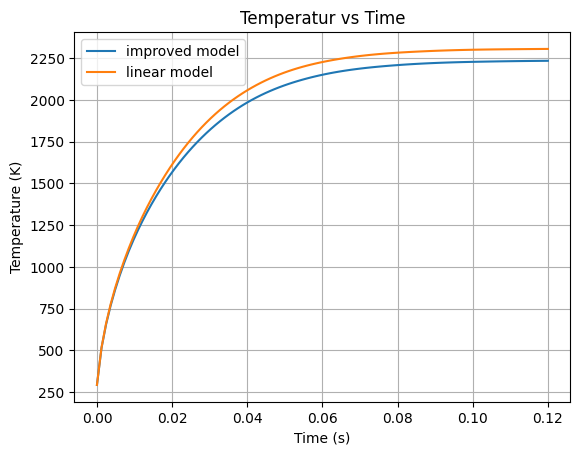

In [33]:
plt.plot(t, T2, label='improved model')
plt.plot(t, T, label='linear model')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Temperatur vs Time')
plt.legend()
plt.grid()
plt.show()

As expected, the equilibrium temperature is slightly lower due to the nonlinear increase of resisitivity.

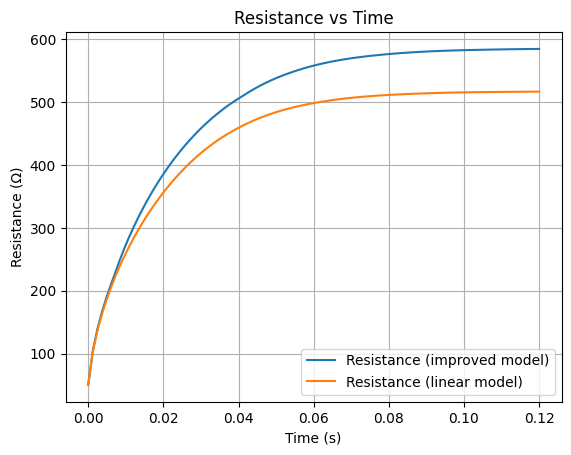

In [34]:
# define function for resistance according to improved model
def R2(T):
    return rel_int(T) * L / (pi * (d/2)**2)

plt.plot(t, R2(T2), label='Resistance (improved model)')
plt.plot(t, R(T), label='Resistance (linear model)')
plt.xlabel('Time (s)')
plt.ylabel('Resistance (Ω)')
plt.title('Resistance vs Time')
plt.legend()
plt.grid()
plt.show()

The resistance at the operational temperature is significantly higher than predicted by the linear model.

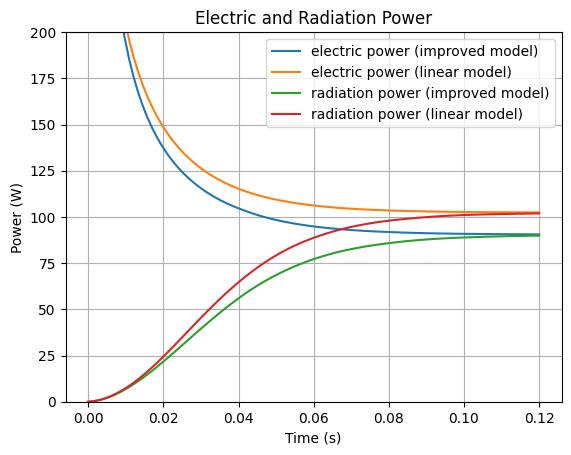

In [35]:
# define function for input power according to improved model
def Pel2(T):
    return k2 * rel / rel_int(T)

plt.plot(t, Pel2(T2), label='electric power (improved model)')
plt.plot(t, Pel(T), label='electric power (linear model)')
plt.plot(t, Prad(T2), label='radiation power (improved model)')
plt.plot(t, Prad(T), label='radiation power (linear model)')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.ylim(0, 200)
plt.title('Electric and Radiation Power')
plt.legend()
plt.grid()
plt.show()

The equilibrium power is slightly lower than predicted by the linear model.